In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
fetch_housing_data()
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [3]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()
# total_bedrooms only 20433 out of 20640 are non-null

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
# which cateogory has how many values?
housing["ocean_proximity"].value_counts()


<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
housing.describe()
#  percentile implies the percentage of the population that belongs to the  below value

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


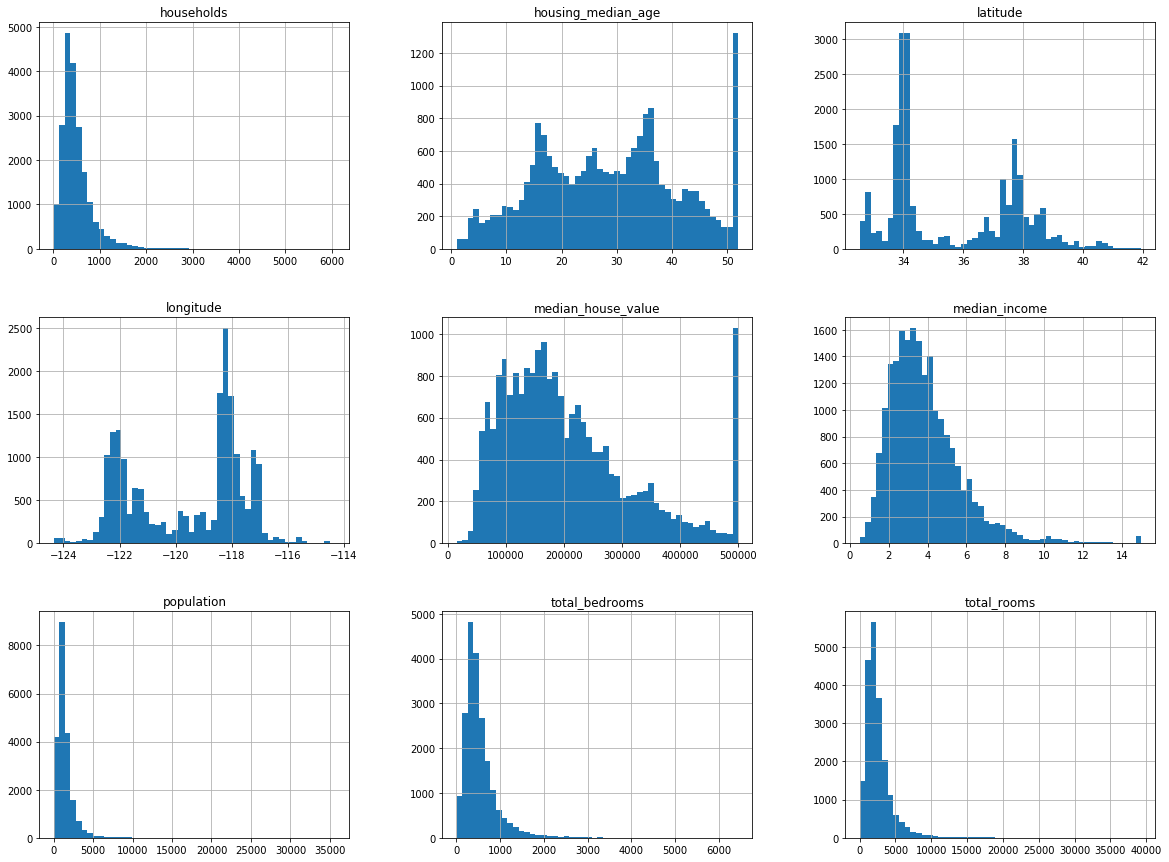

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.hist.html
housing.hist(bins=50, figsize=(20, 15))
plt.show()

In [8]:
import numpy as np
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [9]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), len(test_set))

16512 4128


In [10]:
#  above method is not appropriate since the test set will change every time or training set might get into the test set
from zlib import crc32

# https://www.geeksforgeeks.org/zlib-crc32-in-python/
def test_set_check(identifier, test_ratio):
#   & = Does a "bitwise and". Each bit of the output is 1 if the corresponding bit of x AND of y is 1, otherwise it's 0.
#   take the number on the left and return true if it is  less than 2
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
#     print(in_test_set) true or false for each row
    return data.loc[~in_test_set], data.loc[in_test_set]

In [11]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [12]:
# in order to implement the above case, data must be added to the back and the exisiting cell should not changed,
# if not, add another id as an index.
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [13]:
# or use sklearn func
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [14]:
train_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND
...,...,...,...,...,...,...,...,...,...,...
11284,-117.96,33.78,35.0,1330.0,201.0,658.0,217.0,6.3700,229200.0,<1H OCEAN
11964,-117.43,34.02,33.0,3084.0,570.0,1753.0,449.0,3.0500,97800.0,INLAND
5390,-118.38,34.03,36.0,2101.0,569.0,1756.0,527.0,2.9344,222100.0,<1H OCEAN
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0,<1H OCEAN


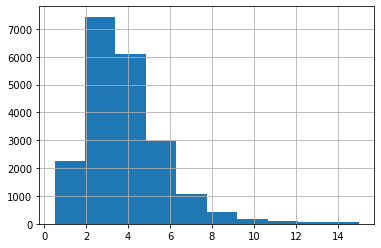

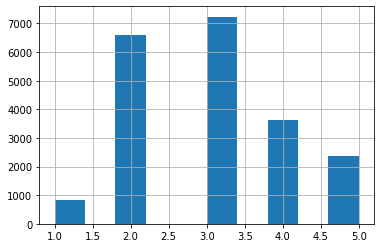

In [15]:
# ceil - round it up
housing["median_income"].hist()
plt.show()
# housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# # Replace values where the condition is False.
# housing["income_cat"].where(housing["income_cat"]  < 5, 5.0, inplace=True)
# housing["income_cat"].hist(bins=30)
# ----------------------------------------------------------
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist()
# ----------------------------------------------------------
plt.show()

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit
# n_splits Number of re-shuffling & splitting iterations.
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# split.split --> Generate indices to split data into training and test set.
# Stratification is done based on the y labels (housing["income_cat"]).
# the proportion of income_category is maintained at test data
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [17]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [18]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


In [19]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([0, 0, 0, 1, 1, 1])
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
sss.get_n_splits(X, y)
print(sss)
# StratifiedShuffleSplit(n_splits=5, random_state=0, ...)
for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(y_test);print(X_test)

StratifiedShuffleSplit(n_splits=10, random_state=0, test_size=0.2,
            train_size=None)
TRAIN: [2 5 1 3] TEST: [0 4]
[0 1]
[[1 2]
 [1 2]]
TRAIN: [0 4 3 1] TEST: [2 5]
[0 1]
[[1 2]
 [3 4]]
TRAIN: [0 4 3 1] TEST: [2 5]
[0 1]
[[1 2]
 [3 4]]
TRAIN: [5 4 1 2] TEST: [0 3]
[0 1]
[[1 2]
 [3 4]]
TRAIN: [1 5 2 4] TEST: [0 3]
[0 1]
[[1 2]
 [3 4]]
TRAIN: [0 5 4 1] TEST: [3 2]
[1 0]
[[3 4]
 [1 2]]
TRAIN: [0 4 1 3] TEST: [5 2]
[1 0]
[[3 4]
 [1 2]]
TRAIN: [2 5 1 3] TEST: [0 4]
[0 1]
[[1 2]
 [1 2]]
TRAIN: [4 1 2 3] TEST: [0 5]
[0 1]
[[1 2]
 [3 4]]
TRAIN: [2 0 3 4] TEST: [1 5]
[0 1]
[[3 4]
 [3 4]]


In [20]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [21]:
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [22]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

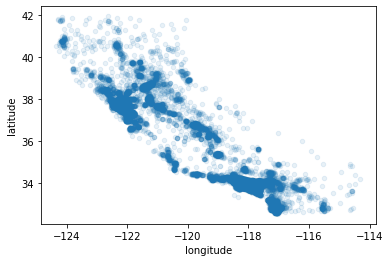

In [23]:
housing = strat_train_set.copy()
# alpha = 0.1 --> show densed area
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

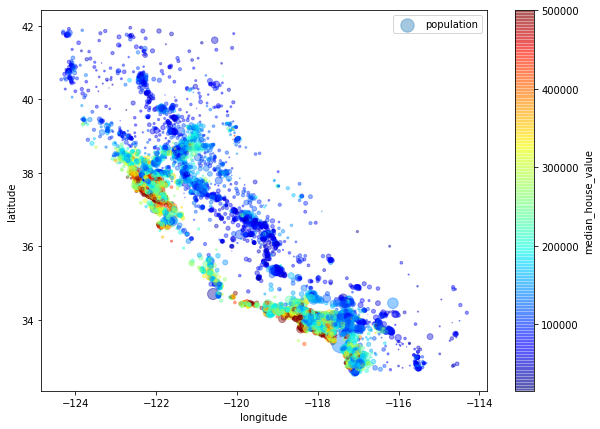

In [24]:
# s, radius - population, c, color -> median house value
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"] / 100, label="population", c="median_house_value",
             cmap=plt.get_cmap("jet"), colorbar= True, sharex=False, figsize=(10, 7))
plt.legend()

In [25]:
# Download the California image
PROJECT_ROOT_DIR = "."
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "Housing")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('.\\images\\Housing\\california.png',
 <http.client.HTTPMessage at 0x23fb683a8c8>)

(674, 594, 3)


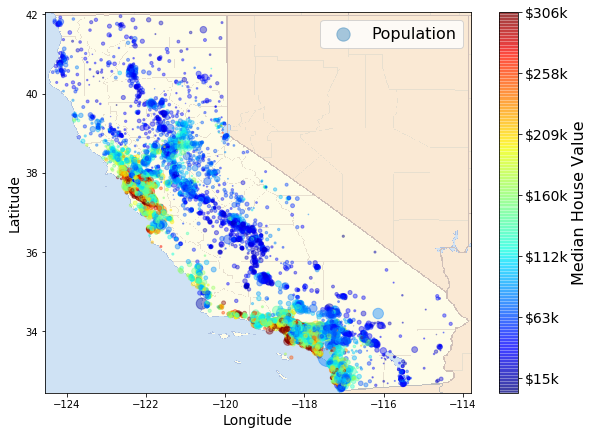

In [26]:
import matplotlib.image as mpimg
# The image module supports basic image loading, rescaling and display operations.
california_img=mpimg.imread(os.path.join(images_path, filename))
print(california_img.shape)
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
# extent option - The bounding box in data coordinates that the image will fill. 
# The image is stretched individually along x and y to fill the box.
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()

In [27]:
corr_matrix= housing.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


In [28]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023FBB6A4D08>,
      dtype=object)

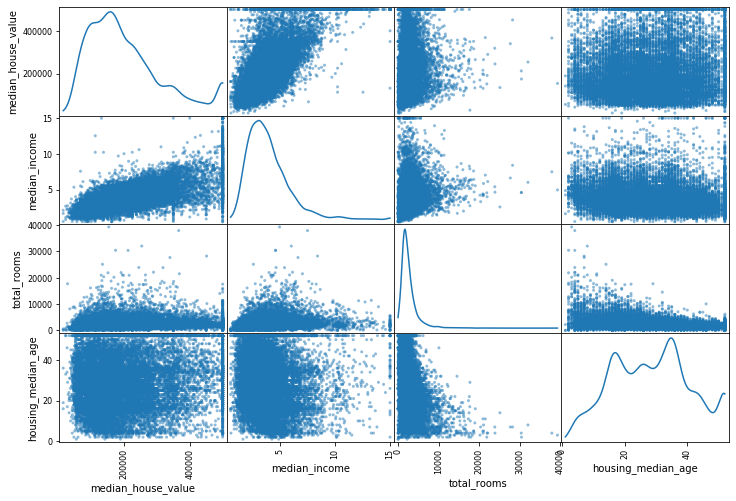

In [32]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8), diagonal='kde')

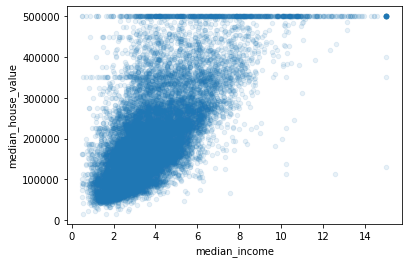

In [33]:
housing.plot(kind='scatter', x = "median_income", y="median_house_value", alpha=0.1)

In [34]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN,4.625369,0.223852,2.094395
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN,6.008850,0.159057,2.707965
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN,4.225108,0.241291,2.025974
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND,5.232295,0.200866,4.135977
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN,4.505810,0.231341,3.047847
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312,240200.0,INLAND,6.052381,0.185681,2.728571
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,113000.0,INLAND,4.635659,0.245819,4.077519
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,97800.0,INLAND,6.346405,0.179609,2.742484
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,225900.0,<1H OCEAN,5.505618,0.193878,3.808989


In [35]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [36]:
housing = strat_train_set.drop("median_house_value", axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN
...,...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312,INLAND
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,INLAND
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,INLAND
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,<1H OCEAN


In [37]:
# data processing
# remove N/A rows
# housing.dropna(subset=["total_bedrooms"])
# remove all attribute
# housing.drop("total_bedrooms", axis=1)
# here, median value is training set's median
median = housing["total_bedrooms"].median()
# when filling out with median value, test set must get same median value as well. 
# Because the model has trained using that median value
housing["total_bedrooms"].fillna(median, inplace=True)

In [38]:
from sklearn.impute import SimpleImputer
# Imputation transformer for completing missing values.
# Algorithms that attempt to fill in (or impute) missing values are referred to as imputation algorithms.
imputer = SimpleImputer(strategy = "median")
housing_num = housing.drop("ocean_proximity", axis=1)

In [39]:
imputer.fit(housing_num)
# median values are saved at statistics_ field
print(imputer.statistics_)
housing_num.median().values

[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [40]:
X = imputer.transform(housing_num)
# X is a np.array so change it to  pd again
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                         index = housing.index)
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347
...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625


In [41]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [42]:
from sklearn.preprocessing import OrdinalEncoder
# OrdinalEncoder - Encode categorical features as an integer array.
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [43]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [44]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
# The features are encoded using a one-hot (aka one-of-K’or dummy) encoding scheme.
# This creates a binary column for each category and returns a sparse matrix or dense array
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
# sparse matrix compressed in terms of row
# print(housing_cat_1hot)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [45]:
# convert it to a dense array
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [46]:
#  we did text --> number category --> one-hot vector.
# we can do this at all at once --> getdummies func
pd.get_dummies(housing_cat)

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
17606,1,0,0,0,0
18632,1,0,0,0,0
14650,0,0,0,0,1
3230,0,1,0,0,0
3555,1,0,0,0,0
...,...,...,...,...,...
6563,0,1,0,0,0
12053,0,1,0,0,0
13908,0,1,0,0,0
11159,1,0,0,0,0


In [47]:
# custom transformer
from sklearn.base import BaseEstimator, TransformerMixin
# sklearn.base --> Base classes for all estimators
# BaseEstimator - Base class for all estimators
# TransformerMixin - > Mixin class for all transformers in scikit-learn.
# "Mixin" --> python object trying to extend it's function

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5 ,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [48]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


In [51]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# the last stage can be transformer or estimator. Before the last stage, they must have transformer so the
# result could be passed down.
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])
# once the fit method is called, transformers listed on the pipeline get executed with fit_transform() method
# the output from the previous stage becomes the input for the next stage
# the last stage only invokes fit() method
housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [52]:
# # old
# from sklearn.base import BaseEstimator, TransformerMixin

# class DataFrameSelector(BaseEstimator, TransformerMixin):
#     def __init__(self, attribute_names):
#         self.attribute_names = attribute_names
#     def fit(self, X, y=None):
#         return self
#     def transform(self, X):
#         return X[self.attribute_names].values

In [53]:
from sklearn.compose import ColumnTransformer
# sklearn.compose: Composite Estimators - Meta-estimators for building composite models with transformers
# Pipelines and composite estimators
# Transformers are usually combined with classifiers, regressors or other estimators
# to build a composite estimator. The most common tool is a Pipeline.
# TransformedTargetRegressor deals with transforming the target (i.e. log-transform y). 
# In contrast, Pipelines only transform the observed data (X).
# ColumnTransformer - This estimator allows different columns or column subsets of the input
# to be transformed separately and the features generated by each transformer will be 
# concatenated to form a single feature space.

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared = pd.DataFrame(
    housing_prepared,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"] + [*set(housing_cat.values[:,0])],
    index=housing.index)
housing_prepared

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household,ISLAND,INLAND,NEAR BAY,<1H OCEAN,NEAR OCEAN
17606,-1.156043,0.771950,0.743331,-0.493234,-0.445438,-0.636211,-0.420698,-0.614937,-0.312055,-0.086499,0.155318,1.0,0.0,0.0,0.0,0.0
18632,-1.176025,0.659695,-1.165317,-0.908967,-1.036928,-0.998331,-1.022227,1.336459,0.217683,-0.033534,-0.836289,1.0,0.0,0.0,0.0,0.0
14650,1.186849,-1.342183,0.186642,-0.313660,-0.153345,-0.433639,-0.093318,-0.532046,-0.465315,-0.092405,0.422200,0.0,0.0,0.0,0.0,1.0
3230,-0.017068,0.313576,-0.290520,-0.362762,-0.396756,0.036041,-0.383436,-1.045566,-0.079661,0.089736,-0.196453,0.0,1.0,0.0,0.0,0.0
3555,0.492474,-0.659299,-0.926736,1.856193,2.412211,2.724154,2.570975,-0.441437,-0.357834,-0.004194,0.269928,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6563,0.722267,-0.673331,1.379547,-0.632123,-0.725361,-0.759010,-0.764049,0.554158,0.234352,-0.031755,-0.428853,0.0,1.0,0.0,0.0,0.0
12053,1.007011,-0.823004,0.902385,-0.667196,-0.584183,-0.329664,-0.636291,-0.948815,-0.308114,0.084689,0.491503,0.0,1.0,0.0,0.0,0.0
13908,1.586489,-0.724781,-1.562952,1.043901,0.822735,0.607904,0.713156,-0.316705,0.346934,-0.030554,-0.521776,0.0,1.0,0.0,0.0,0.0
11159,0.782213,-0.851068,0.186642,-0.309919,-0.374849,-0.057178,-0.375451,0.098121,0.024995,0.061509,-0.303407,1.0,0.0,0.0,0.0,0.0


In [54]:
# # old
# num_attribs = list(housing_num)
# cat_attribs = ["ocean_proximity"]

# num_pipeline = Pipeline([
#     ('selector', DataFrameSelector(num_attribs)),
#     ('imputer', Imputer(strategy="median")),
#     ('attribs_adder', CombinedAttributesAdder()),
#     ('std_scaler', StandardScaler())
# ])

# cat_pipeline = Pipeline([
#     ('selector', DataFrameSelector(cat_attribs)),
#     ('cat_encoder', OneHotEncoder(sparse=False))
# ])


In [55]:
# # old
# from sklearn.pipeline import FeatureUnion

# full_pipeline = FeatureUnion(transformer_list=[
#     ("num_pipeline", num_pipeline),
#     ("cat_pipeline", cat_pipeline)
# ])

In [56]:
# old
# housing_prepared = full_pipeline.fit_transform(housing)
# housing_prepared

In [57]:
housing_prepared.shape

(16512, 16)

In [58]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [59]:
# 예측할 대상
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print('예측: ', lin_reg.predict(some_data_prepared))
print("레이블: ", list(some_labels) )

예측:  [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
레이블:  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [60]:
#RMSE이용
from sklearn.metrics import mean_squared_error
# sklearn.metrics - The sklearn.metrics module includes score functions, 
# performance metrics and pairwise metrics and distance computations.
# when measuring rmse(error), compare the model's result using the training set used to make model and the 
# actual data
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

In [61]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [62]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [63]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                       scoring= "neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
tree_rmse_scores

array([69133.77814723, 65305.86010803, 70256.88987278, 69543.79405016,
       72152.40303861, 74769.46609092, 69957.01102677, 70495.99229502,
       74507.30062835, 69817.9071018 ])

In [64]:
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("STD: ", scores.std())
display_scores(tree_rmse_scores)

Scores:  [69133.77814723 65305.86010803 70256.88987278 69543.79405016
 72152.40303861 74769.46609092 69957.01102677 70495.99229502
 74507.30062835 69817.9071018 ]
Mean:  70594.04023596628
STD:  2598.2299109008954


In [65]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                       scoring= "neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores:  [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean:  69052.46136345083
STD:  2731.6740017983493


In [66]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                       scoring= "neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores:  [49519.80364233 47461.9115823  50029.02762854 52325.28068953
 49308.39426421 53446.37892622 48634.8036574  47585.73832311
 53490.10699751 50021.5852922 ]
Mean:  50182.303100336096
STD:  2097.0810550985693


In [ ]:
from sklearn.externals import joblib
# joblib.dump(forest_reg, 'forest_model.pkl')

In [67]:
from sklearn.model_selection import GridSearchCV
# GridSearchCV - Exhaustive search over specified parameter values for an estimator.
# Important members are fit, predict. GridSearchCV implements a “fit” and a “score” method. 
# Bootstrap - The bootstrap method is a resampling technique used to estimate statistics on a population 
# by sampling a dataset with replacement.  A.K.A - sample with replacement. choose one observation, put it
# back, and choose another. repeat

param_grid = [
    # 하이퍼파라미터 12(=3×4)개의 조합을 시도합니다.
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # bootstrap은 False로 하고 6(=2×3)개의 조합을 시도합니다.
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# 다섯 폴드에서 훈련하면 총 (12+6)*5=90번의 훈련이 일어납니다.
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', 
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [68]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [87]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

In [69]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [70]:
cvres = grid_search.cv_results_
for mean_score, params, in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63669.11631261028 {'max_features': 2, 'n_estimators': 3}
55627.099719926795 {'max_features': 2, 'n_estimators': 10}
53384.57275149205 {'max_features': 2, 'n_estimators': 30}
60965.950449450494 {'max_features': 4, 'n_estimators': 3}
52741.04704299915 {'max_features': 4, 'n_estimators': 10}
50377.40461678399 {'max_features': 4, 'n_estimators': 30}
58663.93866579625 {'max_features': 6, 'n_estimators': 3}
52006.19873526564 {'max_features': 6, 'n_estimators': 10}
50146.51167415009 {'max_features': 6, 'n_estimators': 30}
57869.25276169646 {'max_features': 8, 'n_estimators': 3}
51711.127883959234 {'max_features': 8, 'n_estimators': 10}
49682.273345071546 {'max_features': 8, 'n_estimators': 30}
62895.06951262424 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.176157539405 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.40652318466 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52724.9822587892 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [72]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.082579,0.013253,0.005187,9.764458e-04,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.837622e+09,-4.147108e+09,...,-4.053756e+09,1.519591e+08,18,-1.064113e+09,-1.105142e+09,-1.116550e+09,-1.112342e+09,-1.129650e+09,-1.105559e+09,2.220402e+07
1,0.244075,0.010380,0.011733,2.235594e-03,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.047771e+09,-3.254861e+09,...,-3.094374e+09,1.327062e+08,11,-5.927175e+08,-5.870952e+08,-5.776964e+08,-5.716332e+08,-5.802501e+08,-5.818785e+08,7.345821e+06
2,0.728512,0.058873,0.029127,7.504992e-04,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.689185e+09,-3.021086e+09,...,-2.849913e+09,1.626875e+08,9,-4.381089e+08,-4.391272e+08,-4.371702e+08,-4.376955e+08,-4.452654e+08,-4.394734e+08,2.966320e+06
3,0.111221,0.001634,0.004005,2.520273e-05,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.730181e+09,-3.786886e+09,...,-3.716847e+09,1.631510e+08,16,-9.865163e+08,-1.012565e+09,-9.169425e+08,-1.037400e+09,-9.707739e+08,-9.848396e+08,4.084607e+07
4,0.364955,0.006847,0.010375,4.874573e-04,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.666283e+09,-2.784511e+09,...,-2.781618e+09,1.268607e+08,8,-5.097115e+08,-5.162820e+08,-4.962893e+08,-5.436192e+08,-5.160297e+08,-5.163863e+08,1.542862e+07
5,1.089887,0.019603,0.028728,7.428824e-04,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.387153e+09,-2.588448e+09,...,-2.537883e+09,1.214614e+08,3,-3.838835e+08,-3.880268e+08,-3.790867e+08,-4.040957e+08,-3.845520e+08,-3.879289e+08,8.571233e+06
6,0.146436,0.003847,0.004192,4.017831e-04,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.119657e+09,-3.586319e+09,...,-3.441458e+09,1.893056e+08,14,-9.245343e+08,-8.886939e+08,-9.353135e+08,-9.009801e+08,-8.624664e+08,-9.023976e+08,2.591445e+07
7,0.483324,0.002729,0.010567,4.968005e-04,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.549663e+09,-2.782039e+09,...,-2.704645e+09,1.471569e+08,6,-4.980344e+08,-5.045869e+08,-4.994664e+08,-4.990325e+08,-5.055542e+08,-5.013349e+08,3.100456e+06
8,1.462441,0.000928,0.029831,3.058841e-03,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.370010e+09,-2.583638e+09,...,-2.514673e+09,1.285080e+08,2,-3.838538e+08,-3.804711e+08,-3.805218e+08,-3.856095e+08,-3.901917e+08,-3.841296e+08,3.617057e+06
9,0.184610,0.001818,0.003991,3.234067e-07,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.353504e+09,-3.348552e+09,...,-3.348850e+09,1.241939e+08,13,-9.228123e+08,-8.553031e+08,-8.603321e+08,-8.881964e+08,-9.151287e+08,-8.883545e+08,2.750227e+07


In [73]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [74]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49150.70756927707 {'max_features': 7, 'n_estimators': 180}
51389.889203389284 {'max_features': 5, 'n_estimators': 15}
50796.155224308866 {'max_features': 3, 'n_estimators': 72}
50835.13360315349 {'max_features': 5, 'n_estimators': 21}
49280.9449827171 {'max_features': 7, 'n_estimators': 122}
50774.90662363929 {'max_features': 3, 'n_estimators': 75}
50682.78888164288 {'max_features': 3, 'n_estimators': 88}
49608.99608105296 {'max_features': 5, 'n_estimators': 100}
50473.61930350219 {'max_features': 3, 'n_estimators': 150}
64429.84143294435 {'max_features': 5, 'n_estimators': 2}


In [75]:
rnd_search.best_params_

{'max_features': 7, 'n_estimators': 180}

In [76]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

In [77]:
extra_attribs = ["rooms_per_hold", "pop_per_hold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude'),
 (0.056419179181954014, 'rooms_per_hold'),
 (0.053351077347675815, 'bedrooms_per_room'),
 (0.04114379847872964, 'housing_median_age'),
 (0.014874280890402769, 'population'),
 (0.014672685420543239, 'total_rooms'),
 (0.014257599323407808, 'households'),
 (0.014106483453584104, 'total_bedrooms'),
 (0.010311488326303788, '<1H OCEAN'),
 (0.0028564746373201584, 'NEAR OCEAN'),
 (0.0019604155994780706, 'NEAR BAY'),
 (6.0280386727366e-05, 'ISLAND')]

In [80]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47730.22690385927

In [82]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions-y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))
# sem - Compute standard error of the mean.

array([45685.10470776, 49691.25001878])

In [83]:
# manual version of above
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(45685.10470776, 49691.25001877858)

In [84]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(45685.717918136455, 49690.68623889413)